### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from scipy.stats import chi2_contingency

# models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# metric used for the competition
from sklearn.metrics import f1_score

### Methods

In [2]:
def transform_column(value):
    if isinstance(value, str):
        if 'one' in value.lower() or 'first' in value.lower() or '1' in value:
            return 1
        elif 'two' in value.lower() or 'second' in value.lower() or '2' in value:
            return 2
        elif 'three' in value.lower() or 'third' in value.lower() or '3' in value or '3.00' in value:
            return 3
        elif 'four' in value.lower() or 'fourth' in value.lower() or '4' in value:
            return 4
        elif 'five' in value.lower() or 'fifth' in value.lower() or '5' in value:
            return 5
        else:
            return value
    else:
        return value
    
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def transform_use(x) :
    if x == 'Private Use' or x == 'Private' or x == 'Prvt' or x == 'Privste' :
        return 'private'
    elif x == 'Public' or x =='Public Space' or x == 'Public Use' :
        return 'public'
    elif x == 'Unknown' or x == 'Unspecified' or x == 'Other' :
        return 'other'
    elif x == 'Institutional Use' or x == 'Institutionals' or x == 'Institutional' :
        return 'institutional'
            
        

### Import Data and Data Overview

In [3]:
path = "..\\Datasets\\train.csv.zip"
data = pd.read_csv(path,compression="zip", index_col = "Unnamed: 0")
TARGET = 'damage_grade'
data.head()

d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
4,just 2 floor,22.0,290 ft^2,17.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,Clay,Timber Mud or Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,1.0


In [23]:
data['technical_solution_proposed'].unique()

array([nan, 'Reconstruction', 'Major repair', 'No need', 'Minor repair'],
      dtype=object)

In [17]:
data.shape

(722815, 24)

In [16]:
data.isna().sum()

floors_before_eq (total)          332806
old_building                      239204
plinth_area (ft^2)                421208
height_before_eq (ft)             332806
land_surface_condition            301606
type_of_foundation                239204
type_of_roof                      421208
type_of_ground_floor              332806
type_of_other_floor               301606
position                          312006
building_plan_configuration       301606
technical_solution_proposed       676014
legal_ownership_status            124802
has_secondary_use                 197604
type_of_reinforcement_concrete    291206
residential_type                  270404
no_family_residing                145602
public_place_type                      0
industrial_use_type               114402
govermental_use_type              249604
flexible_superstructure            62400
wall_binding                       62400
wall_material                     228804
damage_grade                           0
dtype: int64

In [19]:
data.duplicated().sum()

335076

In [10]:
data.info() # info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722815 entries, 0 to 37198
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        390009 non-null  object 
 1   old_building                    483611 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           390009 non-null  float64
 4   land_surface_condition          421209 non-null  object 
 5   type_of_foundation              483611 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            390009 non-null  object 
 8   type_of_other_floor             421209 non-null  object 
 9   position                        410809 non-null  object 
 10  building_plan_configuration     421209 non-null  object 
 11  technical_solution_proposed     46801 non-null   object 
 12  legal_ownership_s

In [11]:
data.describe() # numerical description

,old_building,height_before_eq (ft),has_secondary_use,type_of_reinforcement_concrete,wall_binding,wall_material,damage_grade
count,483611.000000,390009.000000,525211.000000,431609.000000,660415.000000,494011.000000,722815.000000
mean,24.342800,16.047158,0.121279,0.072369,4.266729,1.738795,3.643872
std,64.963571,5.527362,0.326451,0.318483,1.667539,0.646120,1.342427
min,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.000000,12.000000,0.000000,0.000000,5.000000,2.000000,3.000000
50%,16.000000,16.000000,0.000000,0.000000,5.000000,2.000000,4.000000
75%,27.000000,18.000000,0.000000,0.000000,5.000000,2.000000,5.000000
max,999.000000,99.000000,1.000000,3.000000,7.000000,3.000000,5.000000


In [12]:
data.describe(include="object")

,floors_before_eq (total),plinth_area (ft^2),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,building_plan_configuration,technical_solution_proposed,legal_ownership_status,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure
count,390009,301607,421209,483611,301607,390009,421209,410809,421209,46801,598013,452411,577213,722815,608413,473211,660415
unique,47,930,3,12,12,15,11,4,10,4,13,6,11,13,9,3,2
top,Floor two,300 ft^2,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,Private,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
freq,22000,10937,349097,199916,79640,262305,223114,325721,404366,28847,315103,430854,487302,721495,564106,473073,607527


### Basic Visualizations

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='land_surface_condition', ylabel='count'>

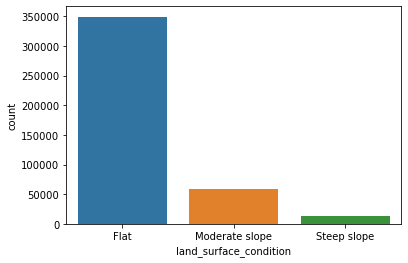

In [9]:
sns.countplot(data['land_surface_condition'])

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='count'>

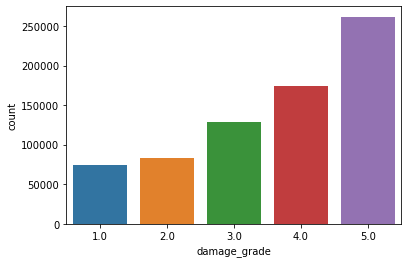

In [15]:
sns.countplot(data['damage_grade'])

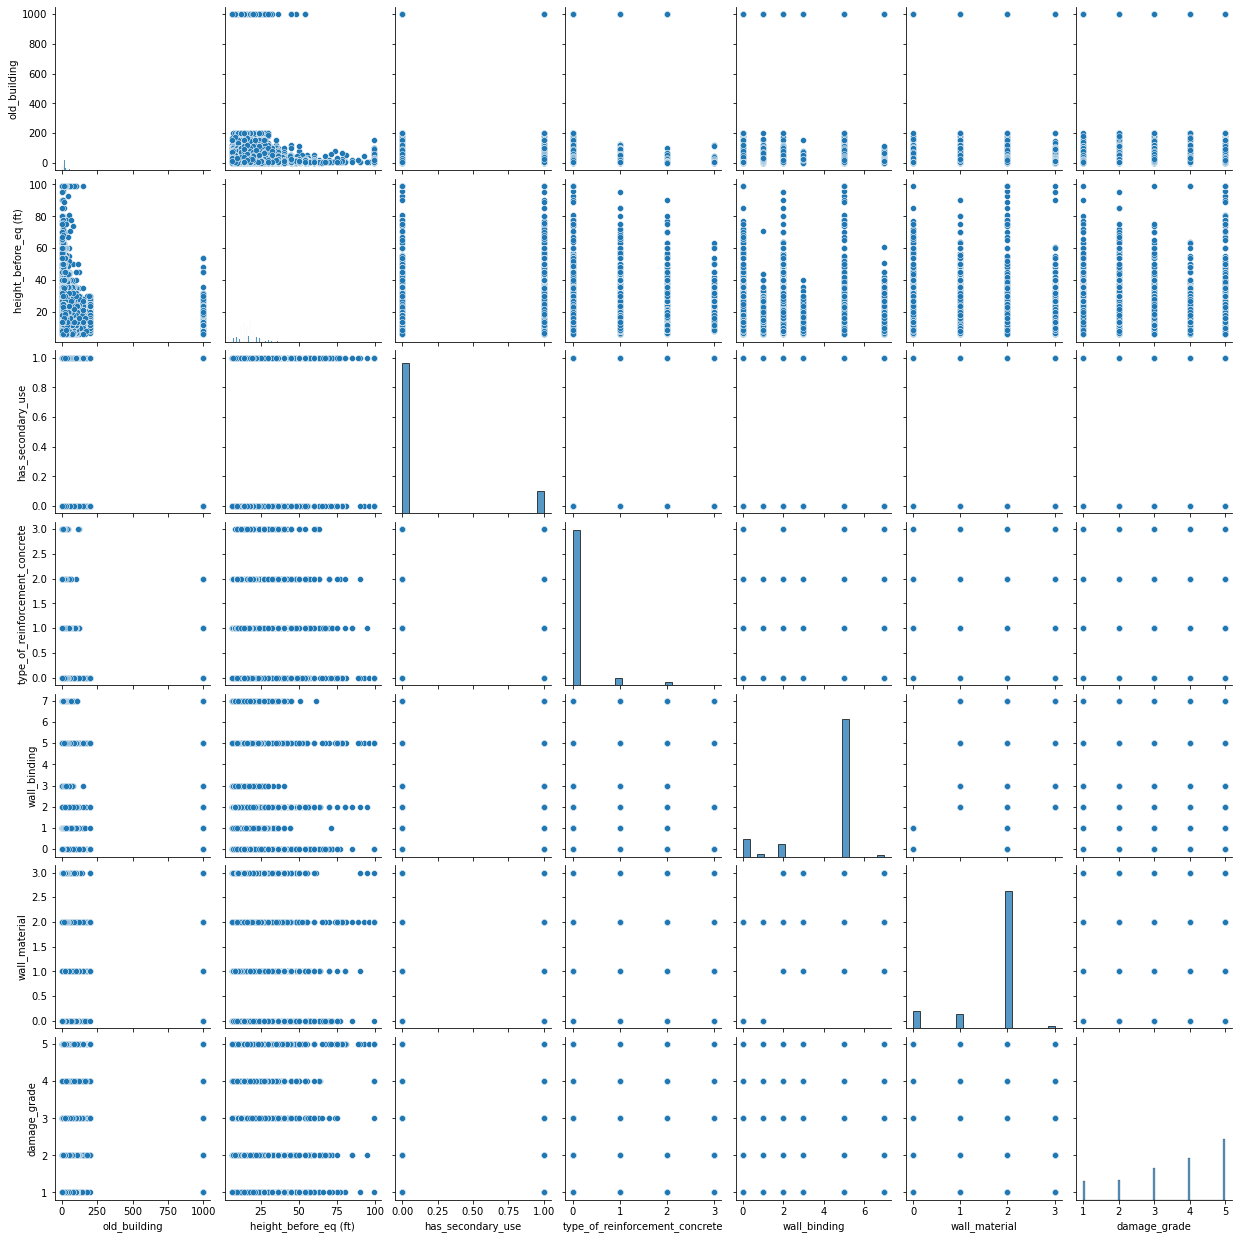

In [20]:
pairs = data.drop_duplicates()
sns.pairplot(pairs)

### Preprocessing

In [4]:
data2 = data.dropna(axis=0).reset_index(drop=True)
data2 = data2.drop(['height_before_eq (ft)', 'wall_binding'], axis=1)
# data2 = data2.dropna(axis=0).reset_index(drop=True)

In [98]:
data2.shape

(46801, 24)

### Method 1 : Dropping all NaN values

In [5]:
data2['no_family_residing'] = data2['no_family_residing'].apply(lambda x: 0 if x == 'None' else int(float(x)))

data2['legal_ownership_status'] = data2['legal_ownership_status'].apply(lambda x : transform_use(x))

data2['floors_before_eq (total)'] = data2['floors_before_eq (total)'].apply(lambda x: transform_column(x))
data2['floors_before_eq (total)'] = pd.to_numeric(data2['floors_before_eq (total)'])

data2['plinth_area (ft^2)'] = data2['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
data2['plinth_area (ft^2)'] = pd.to_numeric(data2['plinth_area (ft^2)'])

data2['type_of_ground_floor'] = data2['type_of_ground_floor'].str.lower()

# data2 = data2.drop('technical_solution_proposed', axis=1)


In [6]:
# num_concrete = ['has_secondary_use', 'type_of_reinforcement_concrete', 'wall_binding', 'wall_material']
data_num = data2.select_dtypes(include='number')
data_cat = data2.select_dtypes('object')
encoder = OneHotEncoder(drop='first')
concat = pd.concat([data_num, pd.DataFrame(encoder.fit_transform(data_cat).toarray(), columns=encoder.get_feature_names(data_cat.columns))], axis=1)
concat

,floors_before_eq (total),old_building,plinth_area (ft^2),has_secondary_use,type_of_reinforcement_concrete,no_family_residing,wall_material,damage_grade,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,...,industrial_use_type_Food,industrial_use_type_Forest-based,industrial_use_type_Infrastructure,industrial_use_type_Manufacturing,industrial_use_type_Metallurgy,industrial_use_type_Non-industrial,industrial_use_type_Service/Tourism,govermental_use_type_Non-govermental,govermental_use_type_Police Offices,flexible_superstructure_unavailable
0,1,22.0,300,0.0,0.0,0,2.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,3,22.0,360,0.0,0.0,1,2.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,2,8.0,380,0.0,0.0,1,2.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,2,22.0,250,0.0,0.0,0,2.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,2,7.0,312,0.0,0.0,1,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46796,2,8.0,547,0.0,0.0,2,2.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
46797,1,24.0,234,0.0,0.0,1,2.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
46798,2,10.0,415,0.0,0.0,1,2.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
46799,3,85.0,410,0.0,0.0,1,2.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


<AxesSubplot:>

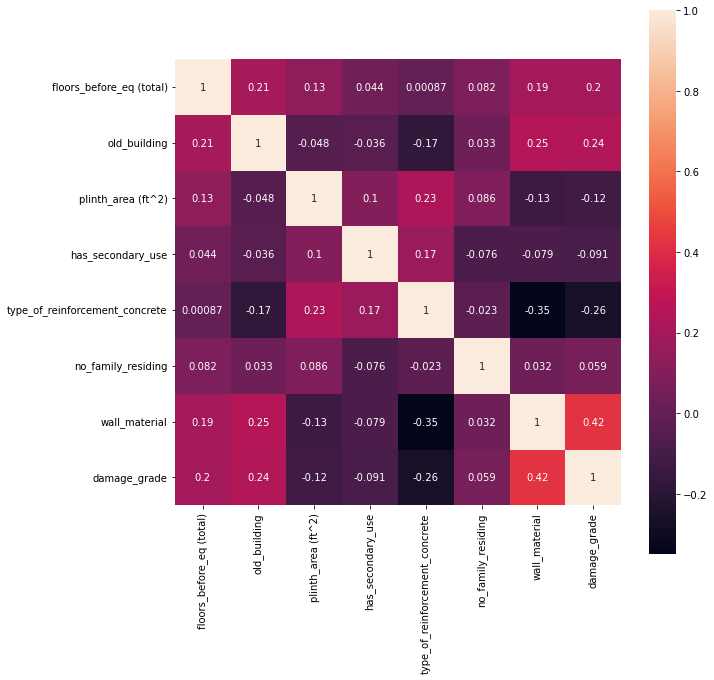

In [24]:
plt.figure(figsize=(10,10))
corr = data2.corr(method='spearman')
sns.heatmap(data=corr, annot=True, square=True)

<AxesSubplot:>

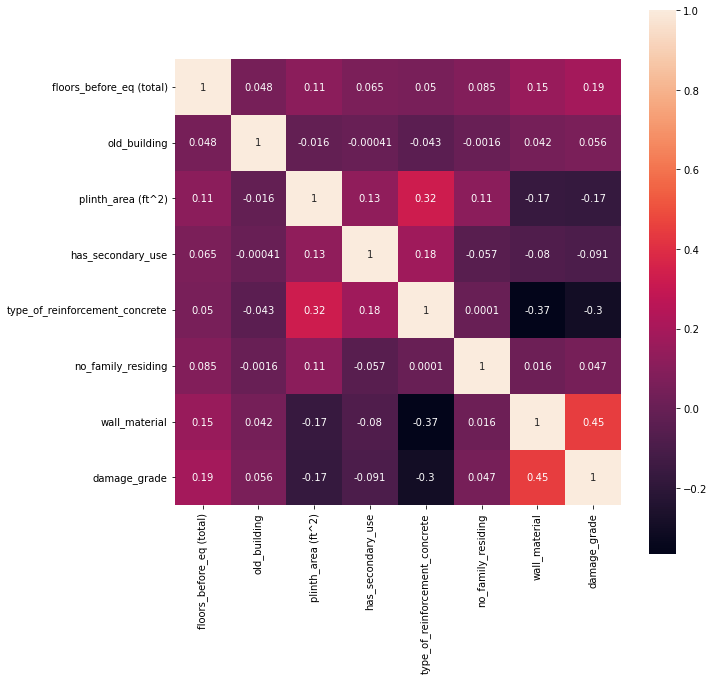

In [25]:
plt.figure(figsize=(10,10))
corr = data2.corr(method='pearson')
sns.heatmap(data=corr, annot=True, square=True)

In [7]:
concat[TARGET] = concat[TARGET].apply(lambda x: x-1)

### Training

In [8]:
X = concat.drop(TARGET, axis=1)
y = concat[TARGET]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
score = cross_val_score(estimator=XGBClassifier(),X=X, y=y, scoring='f1_macro', cv=skf)
score


array([0.64684106, 0.65364516, 0.65376524, 0.64678846, 0.64726481])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [10]:
model = XGBClassifier()
model.fit(X_train, y_train)
result = model.predict(X_test)

In [11]:
score = f1_score(y_test, result, average='macro')
score

0.6440198144616058

### Capping the outliers

In [42]:
data2[data2['old_building'] < 800].max()

floors_before_eq (total)                                  two story
old_building                                                  200.0
plinth_area (ft^2)                              More than 1000 ft^2
height_before_eq (ft)                                          99.0
land_surface_condition                                  Steep slope
type_of_foundation                              Reinforced Concrete
type_of_roof                      reinforced cement concrete/rb/rbc
type_of_ground_floor                        soil, water, loam Mixed
type_of_other_floor               reinforced cement concrete/rb/rbc
position                                               Not attached
building_plan_configuration                                 U-shape
technical_solution_proposed                          Reconstruction
legal_ownership_status                                  Unspecified
has_secondary_use                                               1.0
type_of_reinforcement_concrete                  

### Test Data

In [12]:
test_path = "..\\Datasets\\test.csv.zip"
test = pd.read_csv(test_path,compression="zip", index_col='id')
test = test.drop(['height_before_eq (ft)', 'wall_binding'], axis=1)
test.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,building_plan_configuration,...,legal_ownership_status,has_secondary_use,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_material
id,,,,,,,,,,,,,,,,,,,,,
0,2,7,418 ft^2,Flat,Clay mortar-Stone/Brick,Bamboo/TImber-Light Roof,Clay,TImber/Bamboo-Mud,Not attached,Rectangular,...,Private,0.0,0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,2
1,3.00,13,396 ft^2,Flat,Clay mortar-Stone/Brick,Bamboo/TImber-Heavy Roof,Brick or Stone,TImber/Bamboo-Mud,Not attached,Rectangular,...,Private,0.0,0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,2
2,Floor-three,40,400 ft^2,Flat,Clay mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood or Bamboo Mud,Not attached,Rectangular,...,Private,0.0,0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,2
3,floor second,25,378 ft^2,Flat,Bamboo or Timber,Bamboo/Timber Heavy roof,mud,TImber/Bamboo-Mud,Attached-2 side,Rectangular,...,Private,0.0,0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,2
4,just 2 floor,5,375 ft^2,Flat,Mud mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,Wood-Mud or Bamboo Mud,Attached-1 side,Rectangular,...,Private,0.0,0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,2


In [13]:
test['no_family_residing'] = test['no_family_residing'].apply(lambda x: 0 if x == 'None' else int(float(x)))

test['legal_ownership_status'] = test['legal_ownership_status'].apply(lambda x : transform_use(x))

test['floors_before_eq (total)'] = test['floors_before_eq (total)'].apply(lambda x: transform_column(x))
test['floors_before_eq (total)'] = pd.to_numeric(test['floors_before_eq (total)'])

test['plinth_area (ft^2)'] = test['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
test['plinth_area (ft^2)'] = pd.to_numeric(test['plinth_area (ft^2)'])

test['type_of_ground_floor'] = test['type_of_ground_floor'].str.lower()

In [14]:
# num_concrete = ['has_secondary_use', 'type_of_reinforcement_concrete', 'wall_binding', 'wall_material']
test_num = test.select_dtypes(include='number')
test_cat = test.select_dtypes('object')
test_encoder = OneHotEncoder(drop='first')
test_concat = pd.concat([test_num, pd.DataFrame(test_encoder.fit_transform(test_cat).toarray(), columns=test_encoder.get_feature_names(test_cat.columns))], axis=1)
test_concat

,floors_before_eq (total),old_building,plinth_area (ft^2),has_secondary_use,type_of_reinforcement_concrete,no_family_residing,wall_material,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,type_of_foundation_Bamboo/TImber,...,industrial_use_type_Food,industrial_use_type_Forest-based,industrial_use_type_Infrastructure,industrial_use_type_Manufacturing,industrial_use_type_Metallurgy,industrial_use_type_Non-industrial,industrial_use_type_Service/Tourism,govermental_use_type_Non-govermental,govermental_use_type_Police Offices,flexible_superstructure_unavailable
0,2,7,418,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,3,13,396,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,3,40,400,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,2,25,378,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,2,5,375,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242077,2,15,240,0.0,0,1,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
242078,3,4,174,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
242079,2,14,375,0.0,0,1,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
242080,2,9,486,0.0,0,1,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [15]:
test_result = model.predict(test_concat)

In [18]:
final_result = pd.DataFrame(test_result)

In [19]:
final_result = final_result.rename(columns={0 : 'damage_grade'})
final_result.insert(0, 'id', final_result.index)
final_result = final_result.set_index('id')
final_result['damage_grade'] = final_result['damage_grade'].astype('int')
final_result['damage_grade'] = final_result['damage_grade'].apply(lambda x: x+1)

In [20]:
final_result

,damage_grade
id,
0,5
1,5
2,5
3,5
4,2
...,...
242077,3
242078,5
242079,1


In [21]:
final_result.to_csv('result3_XGB.csv')